In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import warnings
from astropy.wcs import WCS
from astropy.io import fits
from scipy.optimize import curve_fit, root_scalar
from spectral_cube import SpectralCube
from lmfit import Model, Parameters
from scipy.interpolate import interp1d
import aplpy

warnings.filterwarnings('ignore')


In [2]:
# Constants
etamb = 0.89
etaf = 1.0
nu11 = 23.6944955e9
nu22 = 23.7226333e9
h = 6.62606896e-34
kB = 1.3806504e-23
Tbg = 2.73
c = 2.99792458e8
To = 41.5
epsilon = 8.854187817e-12
dipole = 298117.06e6
C_moment = 186726.36e6
mu = 1.476 * 3.336e-30
mu11 = mu ** 2 * (1. / 2.)
Einstein_A = (16. * np.pi ** 3 / (3. * epsilon * h * c ** 3)) * nu11 ** 3 * abs(mu11)
J_Tbg = h * nu11 / kB * (1. / (np.exp(h * nu11 / (kB * Tbg)) - 1))
etac = etamb * etaf
mNH3=17.03      #amu
mH=1.00794      #amu
amu=1.66053886e-27  #kg

In [ ]:
def gaussian(x: np.ndarray, amp: float, cen: float, wid: float) -> np.ndarray:
    return amp * np.exp(-((x - cen)**2) / (2 * wid**2))

def quadrupole(x: np.ndarray, 
               m_amp: float, m_vel: float, m_wid: float, 
               s1_amp: float, s2_amp: float, s3_amp: float, s4_amp: float) -> np.ndarray:
    vel = [-26.023, -16.368, 0.0, 16.368, 26.023]
    return (gaussian(x, s1_amp, m_vel + vel[0], m_wid) +
            gaussian(x, s2_amp, m_vel + vel[1], m_wid) +
            gaussian(x, m_amp, m_vel , m_wid) +
            gaussian(x, s3_amp, m_vel + vel[3], m_wid) +
            gaussian(x, s4_amp, m_vel + vel[4], m_wid))
    
def quad_curvefit(x: np.ndarray, y: np.ndarray, peak_vel: float):
    # Bounds for: main amp, main vel, main wid, s1 amp, s2 amp, s3 amp, s4 amp
    func_bounds = ([0, -np.inf, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
    popt, pcov = curve_fit(quadrupole, x, y, bounds = func_bounds)
    return popt, pcov

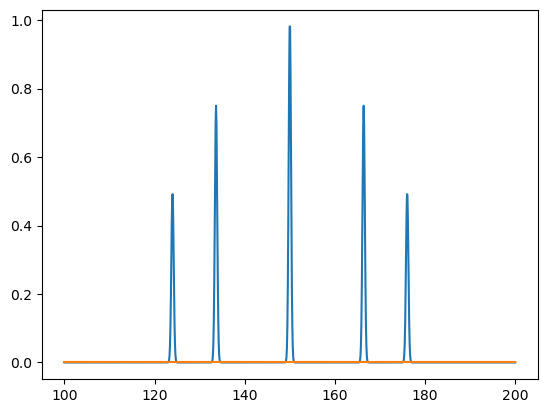

In [25]:
x_data = np.linspace(100, 200, 1000)
params = [1, np.mean(x_data), .26, .5, .75, .75, .5]
y_data = quadrupole(x_data, *params)

fit_popt, fit_pcov = curve_fit(quadrupole, x_data, y_data)

plt.plot(x_data, y_data)
plt.plot(x_data, quadrupole(x_data, *fit_popt))
plt.show()